## **Part 4: Comprehensive Case Study – Recipe Review Ratings Prediction**

In [80]:
# All imports centralized here to avoid repetition, make dependencies explicit, and keep the notebook order-independent and reproducible.
import pandas as pd
import numpy as np
import html
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

### **Loading the dataset: Recipe Reviews and Feedback Data**

In [81]:
data=pd.read_csv('recipe_reviews.csv')
data.shape

(18182, 24)

In [82]:
data.head()

,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,...,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0,1,14299,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000000,0.693147,...,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,1,1,14299,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875000,3.931826,...,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,2,1,14299,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750000,2.397895,...,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,710,I have a very complicated white chicken chili ...,5
3,3,1,14299,2.319913,-0.107932,2.012194,0.865812,585.875342,0.666667,0.693147,...,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,581,"In your introduction, you mentioned cream chee...",0
4,4,1,14299,6.950816,0.142649,1.009770,8.985971,815.148751,0.875000,2.397895,...,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0


### **Data Cleaning**

In [83]:
data.isnull().sum()

Unnamed: 0        0
recipe_number     0
recipe_code       0
likes_score       0
dislike_index     0
response_level    0
user_index        0
ranking_value     0
vote_ratio        0
score_log         0
region            0
device_type       0
recipe_name       0
comment_id        0
user_id           0
user_name         0
user_score        0
created_at        0
responses         0
likes             0
dislikes          0
ranking_score     0
text              2
stars             0
dtype: int64

In [84]:
#delete the "Unnamed" column
data.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)

##### There are no NaN/None values,but the assignment says some missing values were encoded as the literal value 2, so they won’t show up as nulls.

##### We need to scan the dataset to see where the literal string "2" appears so we can treat those as missing later.

Important distinctions:
* "2"(a string) -> typically a placeholder for "unknown" in text/categorical columns.
* 2 (a number) -> a real numeric value (e.g., counts, 2-star rating). We do NOT replace these.

In [85]:
#Audit '2' placeholders across all columns

#Identify the label/target column present in THIS dataset.
_preferred_targets = ["stars", "star_rating", "rating", "review_stars", "likes_score"]
TARGET = next(c for c in _preferred_targets if c in data.columns)
print("TARGET =", TARGET)

#Build an audit table:
#    For every column we record:
#     * dtype
#     * how many times the literal string "2" appears in text/object columns
#     * how many numeric 2's appear in numeric columns (just for awareness)
#     * uniqueness and a small sample of values (to understand the field quickly)
summary_rows = []
for col in data.columns:
    col_dtype = str(data[col].dtype)

    # Count literal "2" ONLY in text/object columns (possible placeholder for missing)
    if pd.api.types.is_object_dtype(data[col]) or pd.api.types.is_string_dtype(data[col]):
        s = data[col].astype("string")
        count_literal_2 = int((s == "2").sum())
    else:
        count_literal_2 = 0

    # Count numeric 2 ONLY in numeric columns (these are real numbers; we won't replace them)
    if pd.api.types.is_numeric_dtype(data[col]):
        count_numeric_2 = int((data[col] == 2).sum())
    else:
        count_numeric_2 = 0

    # Basic profiling info to help explain the column in a glance
    nunique = int(data[col].nunique(dropna=False))
    unique_sample = list(pd.Series(data[col].unique()).astype(str).head(8))

    summary_rows.append({
        "column": col,
        "dtype": col_dtype,
        "n_unique": nunique,
        "count_literal_'2'_in_text": count_literal_2,  # where "2" is a STRING
        "count_numeric_2": count_numeric_2,            # where 2 is a NUMBER
        "note": "TARGET" if col == TARGET else "",
        "unique_sample": unique_sample
    })

audit_2 = pd.DataFrame(summary_rows).sort_values(
    ["count_literal_'2'_in_text", "count_numeric_2"], ascending=False
)

print("\nAudit summary — columns with potential placeholder '2' at the top:")
display(audit_2.head(30))

#If any TEXT columns contain the literal "2", preview a few rows to CONFIRM it's a placeholder.
#  This is a sanity check: we look at examples before we replace anything.
cols_with_text_2 = [row["column"] for row in summary_rows if row["count_literal_'2'_in_text"] > 0]
for col in cols_with_text_2[:5]:  # preview at most 5 columns to keep it concise
    print(f"\nPreview where {col} == '2'  (confirm it's truly a placeholder):")
    display(data.loc[data[col].astype("string") == "2", [col]].head(5))

#Target distribution (RAW = before any cleaning).
# We print "raw" counts so we can see issues we must fix (e.g., 0-star rows).
print("\nTarget value counts ( before cleaning):")
print(data[TARGET].value_counts(dropna=False).sort_index())

TARGET = stars

Audit summary — columns with potential placeholder '2' at the top:


,column,dtype,n_unique,count_literal_'2'_in_text,count_numeric_2,note,unique_sample
18,likes,int64,62,0,624,,"[0, 7, 3, 2, 11, 28, 6, 1]"
0,recipe_number,int64,100,0,509,,"[1, 2, 3, 4, 5, 6, 7, 8]"
19,dislikes,int64,58,0,388,,"[0, 1, 2, 5, 29, 6, 19, 4]"
22,stars,int64,6,0,232,TARGET,"[5, 0, 4, 3, 1, 2]"
17,responses,int64,4,0,24,,"[0, 2, 1, 3]"
1,recipe_code,int64,100,0,0,,"[14299, 3309, 2832, 17826, 42386, 21444, 12540..."
2,likes_score,float64,18182,0,0,,"[0.1043348965735403, 6.970957558839315, 3.1360..."
3,dislike_index,float64,18182,0,0,,"[-0.0870817402832564, -0.0944955342677502, -0...."
4,response_level,float64,18182,0,0,,"[-0.0015798854700673, -0.0021692262281421, 0.0..."
5,user_index,float64,18182,0,0,,"[1.1720321111077867, 50.629458430059344, 10.74..."



Target value counts ( before cleaning):
stars
0     1696
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64


In [86]:
#Clean in place
TARGET = "stars" # We know from the audit that the label column in THIS dataset is 'stars'.
assert TARGET in data.columns, "Expected 'stars' column not found."

print("Before cleaning:", data.shape) 

#Replace STRING "2" → NaN in NON-TARGET TEXT columns
#We EXCLUDE the target so we never erase a legitimate 2-star rating.
obj_cols_non_target = [
    c for c in data.select_dtypes(include=["object","string"]).columns
    if c != TARGET
]
replaced_total = 0  #To report how many placeholders we fixed.

for c in obj_cols_non_target:
    s = data[c].astype("string")
    hits = (s == "2").sum()
    if hits:
        data[c] = s.mask(s == "2", pd.NA)
        replaced_total += int(hits)

print("Placeholders fixed (\"2\" as text → NaN):", replaced_total)

Before cleaning: (18182, 23)
Placeholders fixed ("2" as text → NaN): 0


In [87]:
#Drop exact duplicate rows
before = len(data)
data.drop_duplicates(inplace=True)
print("Exact duplicates dropped:", before - len(data))

Exact duplicates dropped: 0


In [88]:
#Normalize categorical TEXT
for c in obj_cols_non_target:
    s = data[c].astype("string")
    s = s.str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)
    s = s.str.lower()
    s = s.mask(s.eq(""), pd.NA)
    data[c] = s

#Unescape HTML in review text
#(Review text may contain HTML entities ("&amp;#34;" for quotes). Decoding improves readability and downstream NLP.)
if "text" in data.columns: #If I don't check this, pd.NA is not None and got error.
    data["text"] = data["text"].apply(
        lambda x: html.unescape(x) if isinstance(x, str) else x
    )
    print("Unescaped HTML entities in 'text' (pd.NA left untouched).")
else:
    print("Column 'text' not found; skipped HTML unescape.")

Unescaped HTML entities in 'text' (pd.NA left untouched).


In [89]:
#Data type fixes

#Convert UNIX epoch seconds
#datetime in a NEW column to preserve the original numeric if needed later.
if "created_at" in data.columns and pd.api.types.is_integer_dtype(data["created_at"]):
    data["created_at_dt"] = pd.to_datetime(data["created_at"], unit="s", errors="coerce")

#Convert numeric-looking TEXT columns -> numeric when it’s safe.
#math/plots require numeric dtype; converting only when ≥70% of non-null values are numeric avoids wrecking ID-like text.
obj_now = data.select_dtypes(include=["object","string"]).columns.tolist()
for c in obj_now:
    if c == TARGET:
        continue
    ser = data[c].astype("string")
    as_num = pd.to_numeric(ser, errors="coerce")
    nonnull = ser.notna().sum()
    good = as_num.notna().sum()
    if nonnull > 0 and good / nonnull >= 0.70:
        data[c] = as_num

In [90]:
#The audit showed 0’s in 'stars'; those are not valid ratings for a 1–5 classifier, so we remove them.
data[TARGET] = pd.to_numeric(data[TARGET], errors="coerce")
invalid_mask = ~data[TARGET].isin([1, 2, 3, 4, 5])
dropped_invalid = int(invalid_mask.sum())#To report how many rows we are excluding.
data = data.loc[~invalid_mask].copy() #To keep only valid labeled rows for training/EDA.
data[TARGET] = data[TARGET].astype(int) #Integer labels are standard for classifiers/plots.

In [91]:
print("After cleaning:", data.shape)  
print("Target counts:", data[TARGET].value_counts().sort_index().to_dict()) 
print("Top columns by missing values:")
print(data.isna().sum().sort_values(ascending=False).head(10))

After cleaning: (16486, 24)
Target counts: {1: 280, 2: 232, 3: 490, 4: 1655, 5: 13829}
Top columns by missing values:
text              4
recipe_number     0
likes_score       0
recipe_code       0
response_level    0
user_index        0
ranking_value     0
dislike_index     0
vote_ratio        0
score_log         0
dtype: int64


In [92]:
#HANDLE 4 MISSING VALUES IN 'text' 

assert "text" in data.columns, "'text' column not found."
#Ensure string dtype, then replace NA or whitespace-only with "Not given"
data["text"] = data["text"].astype("string")
mask_blank = data["text"].isna() | (data["text"].str.strip().str.len() == 0)
n_fix = int(mask_blank.sum())
data.loc[mask_blank, "text"] = "Not given"

#Verify
print(f"Replaced {n_fix} empty/NA 'text' values with 'Not given'.")
print("Remaining nulls in 'text':", int(data["text"].isna().sum()))

Replaced 4 empty/NA 'text' values with 'Not given'.
Remaining nulls in 'text': 0


In [93]:
# Outlier audit with counts
TARGET = "stars"
NUM = data.select_dtypes(include=[np.number]).columns.drop([TARGET], errors="ignore")

outlier_rows_masks = []
rows = []
for c in NUM:
    s = data[c]
    s_non = s.dropna()
    if s_non.empty:
        continue
    q1, q3 = s_non.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    mask = (s < lo) | (s > hi)  # includes NaNs as False
    n = int(s_non.shape[0])
    n_out = int(mask.sum())
    share = n_out / n if n else 0.0

    rows.append({
        "feature": c, "q1": float(q1), "q3": float(q3), "iqr": float(iqr),
        "lo": float(lo), "hi": float(hi),
        "n": n, "n_outliers": n_out, "outlier_share": round(share, 4),
    })
    outlier_rows_masks.append(mask.fillna(False))

iqr_df = pd.DataFrame(rows).sort_values("outlier_share", ascending=False)
print("Top potential outliers (by share of points outside 1.5 x IQR):")
display(iqr_df.head(10))

# Unique rows that are outliers in ANY numeric feature
any_outlier_mask = pd.concat(outlier_rows_masks, axis=1).any(axis=1) if outlier_rows_masks else pd.Series(False, index=data.index)
print(f"\nRows with any numeric outlier: {int(any_outlier_mask.sum())} within the actual {len(data)} ({any_outlier_mask.mean():.1%})")


Top potential outliers (by share of points outside 1.5 x IQR):


,feature,q1,q3,iqr,lo,hi,n,n_outliers,outlier_share
14,ranking_score,1.000000e+02,1.000000e+02,0.000000,1.000000e+02,1.000000e+02,16486,3735,0.2266
7,vote_ratio,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,16486,3658,0.2219
12,likes,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,16486,3658,0.2219
6,ranking_value,9.676945e+01,1.129568e+02,16.187375,7.248839e+01,1.372379e+02,16486,3555,0.2156
2,likes_score,-9.654828e-02,3.773005e-01,0.473849,-8.073215e-01,1.088074e+00,16486,2603,0.1579
3,dislike_index,-1.003027e-01,1.843760e-01,0.284679,-5.273209e-01,6.113941e-01,16486,2100,0.1274
13,dislikes,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,16486,2098,0.1273
10,created_at,1.622717e+09,1.622718e+09,918.000000,1.622716e+09,1.622720e+09,16486,1266,0.0768
8,score_log,6.931472e-01,6.931472e-01,0.000000,6.931472e-01,6.931472e-01,16486,1166,0.0707
9,user_score,1.000000e+00,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,16486,1166,0.0707



Rows with any numeric outlier: 5511 within the actual 16486 (33.4%)


About 33.4% of rows trigger the 1.5×IQR rule—mainly due to zero-inflated engagement fields (e.g., likes, dislikes) and a few near-constant fields (ranking_score, user_score). We retain all rows for now and will address skew later with log1p where appropriate; no row deletions or caps are applied at this stage.

### Data Cleaning Done.

### **Exploratory Data Analysis (EDA)**

In [94]:
#STRUCTURE & SUMMARY STATISTICS

TARGET = "stars"  # confirmed label from cleaning

#Quick report
print("Rows , Cols:", data.shape)
print("Column names:", list(data.columns))

#Dtype overview
print("\nDtypes (sorted):")
print(data.dtypes.sort_index())

Rows , Cols: (16486, 24)
Column names: ['recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'text', 'stars', 'created_at_dt']

Dtypes (sorted):
comment_id        string[python]
created_at                 int64
created_at_dt     datetime64[ns]
device_type       string[python]
dislike_index            float64
dislikes                   int64
likes                      int64
likes_score              float64
ranking_score              int64
ranking_value            float64
recipe_code                int64
recipe_name       string[python]
recipe_number              int64
region            string[python]
response_level           float64
responses                  int64
score_log                float64
stars                      int64
text             

In [95]:
#Numeric summary stats (excluding the label)
#We add n_missing so it's clear where later imputation might be needed.
num_cols = [c for c in data.select_dtypes(include=[np.number]).columns if c != TARGET]
numeric_summary = data[num_cols].describe().T
numeric_summary["n_missing"] = data.shape[0] - numeric_summary["count"]
numeric_summary = numeric_summary.drop(columns=["count"])
print("\nNumeric summary (first 12 rows):")
display(numeric_summary.head(12))


Numeric summary (first 12 rows):


,mean,std,min,25%,50%,75%,max,n_missing
recipe_number,3.853718e+01,2.987420e+01,1.000000e+00,1.100000e+01,3.200000e+01,6.300000e+01,1.000000e+02,0.0
recipe_code,2.162893e+04,2.425830e+04,3.860000e+02,6.086000e+03,1.429900e+04,3.253500e+04,1.917750e+05,0.0
likes_score,1.020802e+00,3.952783e+00,-8.058902e-01,-9.654828e-02,7.974657e-02,3.773005e-01,1.057669e+02,0.0
dislike_index,4.904052e-01,3.193160e+00,-7.748100e-01,-1.003027e-01,2.726982e-02,1.843760e-01,1.260525e+02,0.0
response_level,1.082334e-02,1.158106e-01,-2.963261e-02,-4.549729e-03,1.472930e-04,4.846804e-03,3.003453e+00,0.0
user_index,2.212846e+00,1.042344e+01,-1.093772e+00,6.781906e-01,1.042261e+00,1.417334e+00,5.204403e+02,0.0
ranking_value,1.511174e+02,1.375124e+02,-7.732879e+00,9.676945e+01,1.026276e+02,1.129568e+02,9.448343e+02,0.0
vote_ratio,1.285011e-01,2.552215e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.767442e-01,0.0
score_log,8.179160e-01,5.303523e-01,0.000000e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.255750e+00,0.0
user_score,2.211573e+00,1.040720e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.200000e+02,0.0


In [96]:
#Small-cardinality categorical summary as they are good candidates for grouped analysis later.
cat_cols = data.select_dtypes(include=["object", "string", "category"]).columns.tolist()
small_cats = [c for c in cat_cols if data[c].nunique(dropna=False) <= 20]
print("\nSmall-cardinality categorical columns (≤20 uniques):", small_cats)

#To see top values for each small categorical
for c in small_cats:
    print(f"\nTop values for '{c}':")
    print(data[c].value_counts(dropna=False).head(5))


Small-cardinality categorical columns (≤20 uniques): ['region', 'device_type']

Top values for 'region':
region
west     4174
north    4149
south    4110
east     4053
Name: count, dtype: Int64

Top values for 'device_type':
device_type
mobile     5526
desktop    5487
tablet     5473
Name: count, dtype: Int64


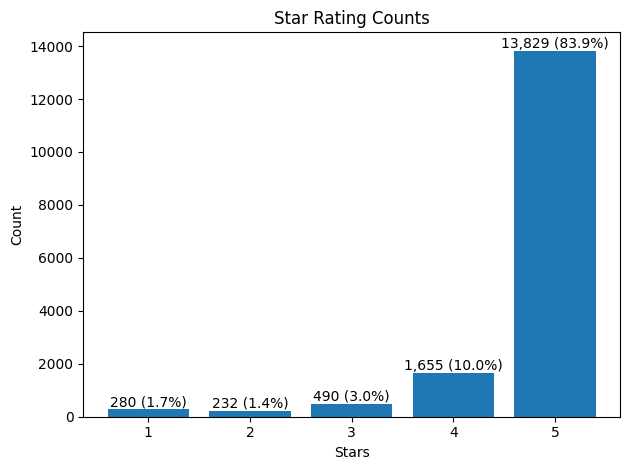

In [97]:
#Visualize distributions and correlations

#Class distribution

TARGET = "stars"

def plot_cat_counts(series, title=None, xlabel=None, show_pct=True):
    counts = series.value_counts(dropna=False).sort_index()
    labels = ["NaN" if pd.isna(x) else str(x) for x in counts.index]
    total = int(counts.sum())

    fig, ax = plt.subplots()
    bars = ax.bar(range(len(counts)), counts.values)

    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(labels)
    ax.set_xlabel(xlabel or series.name)
    ax.set_ylabel("Count")
    ax.set_title(title or f"{series.name} — counts (n={total:,})")

    # annotate bars with count (and percent)
    for rect, val in zip(bars, counts.values):
        txt = f"{int(val):,}"
        if show_pct and total > 0:
            txt += f" ({val/total:.1%})"
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                txt, ha="center", va="bottom", fontsize=10)

    plt.tight_layout(); plt.show()

# Call it for stars
plot_cat_counts(data[TARGET], title="Star Rating Counts", xlabel="Stars", show_pct=True)

Spearman correlation with 'stars' (top 10 by |r|):
dislikes         -0.182415
dislike_index    -0.107472
responses        -0.104867
recipe_number    -0.071416
likes            -0.032577
response_level   -0.030880
likes_score      -0.019372
created_at       -0.019314
ranking_score    -0.018692
vote_ratio       -0.016629
Name: stars, dtype: float64


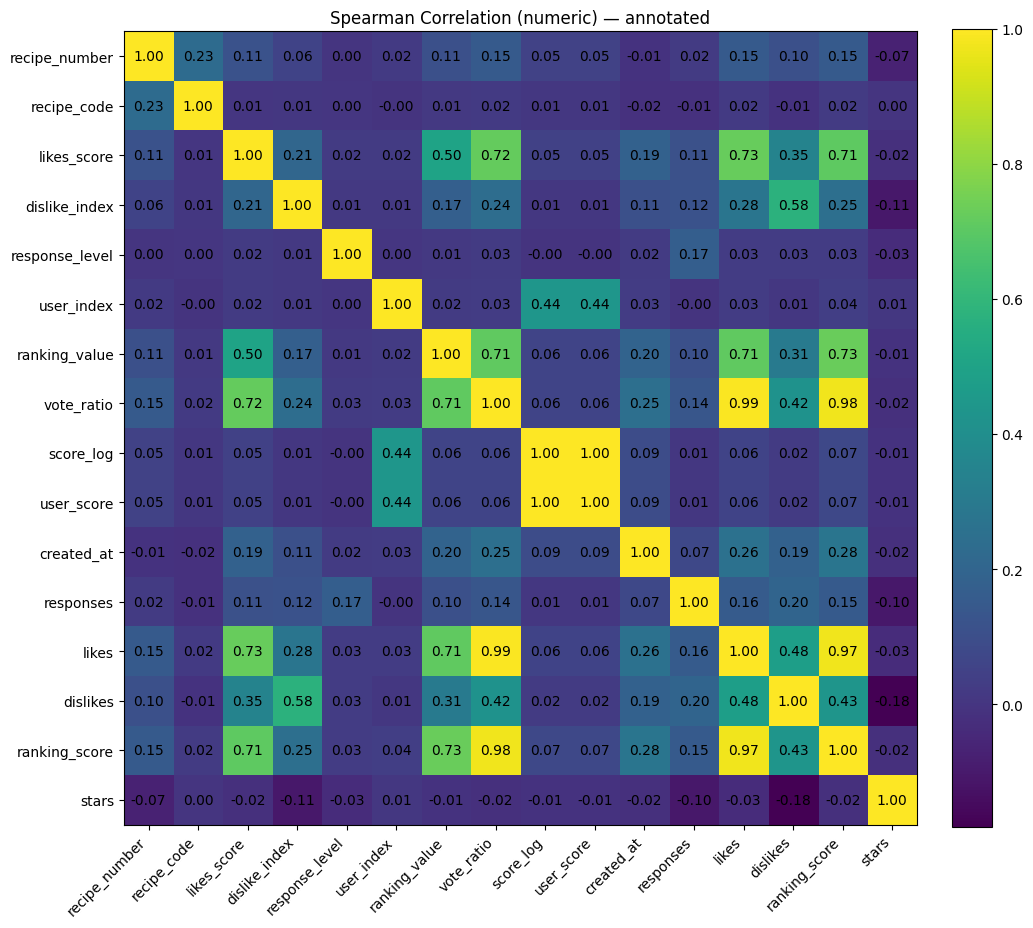

In [98]:
# NUMERIC CORRELATIONS 

# Compute Spearman on numeric columns only (robust to skew/outliers)
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
assert TARGET in num_cols, "Expected numeric target 'stars' not found."
corr = data[num_cols].corr(method="spearman", min_periods=1)  # pairwise-NaN safe

# Rank features by their association with the target (absolute value)
stars_corr = corr[TARGET].drop(TARGET).sort_values(key=lambda s: s.abs(), ascending=False)
print("Spearman correlation with 'stars' (top 10 by |r|):")
print(stars_corr.head(10))

#Use ALL numeric columns (original set) and scale the figure so numbers stay legible
keep = num_cols
corr_small = corr.loc[keep, keep]

#Plot a single annotated heatmap
n = corr_small.shape[0]  # number of features in the grid
fig_w = max(8, 0.7 * n)  # ~0.7 inch per feature (min 8")
fig_h = max(7, 0.7 * n)  # square-ish figure for readability
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

im = ax.imshow(corr_small.values, interpolation="nearest")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(keep)))
ax.set_yticks(np.arange(len(keep)))
ax.set_xticklabels(keep, rotation=45, ha="right")
ax.set_yticklabels(keep)
ax.set_title("Spearman Correlation (numeric) — annotated")

#Write the correlation value into each cell (two decimals for readability)
for i in range(len(keep)):
    for j in range(len(keep)):
        val = corr_small.iat[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.show()


* Strong redundancy cluster:** likes, ranking_score, vote_ratio, likes_score (≈ 0.71–0.99 between them).  
* Tight pair: dislikes and dislike_index.
* Modest link to stars:  strongest magnitude is around 'dislikes' (~−0.18).  Numeric features alone likely won’t explain ratings.

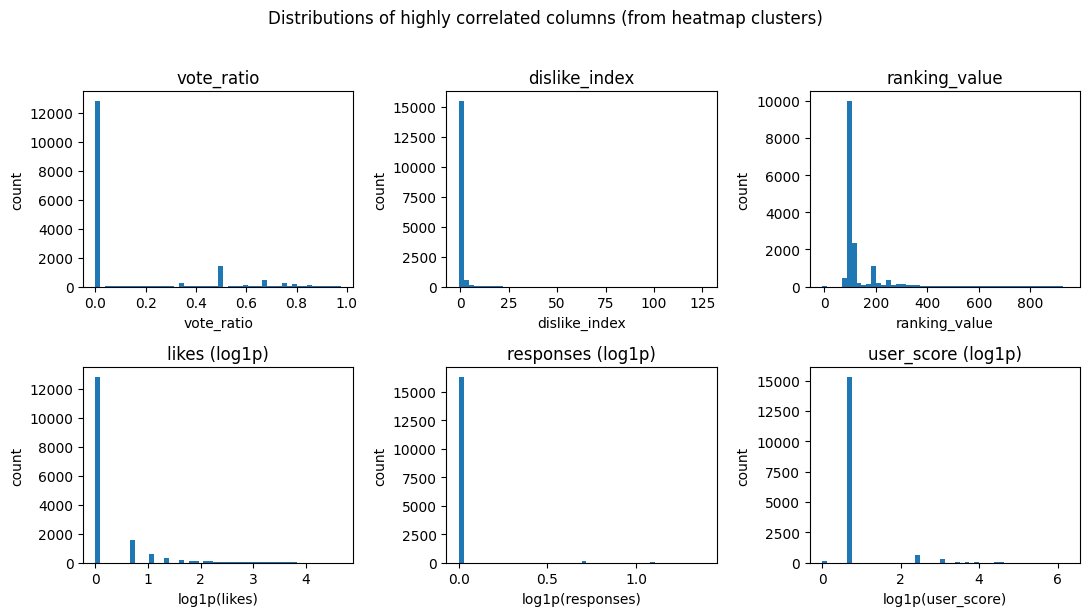

In [99]:
#Histogram of columns from highly-correlated family

selected = [c for c in ["vote_ratio","dislike_index","ranking_value","likes","responses","user_score"] if c in data.columns]
log_cols = [c for c in ["likes","responses","user_score"] if c in selected]

def _num(s): return pd.to_numeric(s, errors="coerce").dropna()

fig, axes = plt.subplots(2, 3, figsize=(11, 6))
axes = axes.ravel()

for i, c in enumerate(selected):
    s = _num(data[c])
    if c in log_cols:
        s = np.log1p(s)
        axes[i].hist(s, bins=50)
        axes[i].set_title(f"{c} (log1p)")
        axes[i].set_xlabel(f"log1p({c})")
    else:
        axes[i].hist(s, bins=50)
        axes[i].set_title(c)
        axes[i].set_xlabel(c)
    axes[i].set_ylabel("count")

for j in range(len(selected), 6):
    axes[j].axis("off")

fig.suptitle("Distributions of highly correlated columns (from heatmap clusters)", y=1.02)
fig.tight_layout()
plt.show()

Histograms + heatmap don’t show how features relate to stars on their own. Therefore, I will do more analysis to explore how features relate to stars.

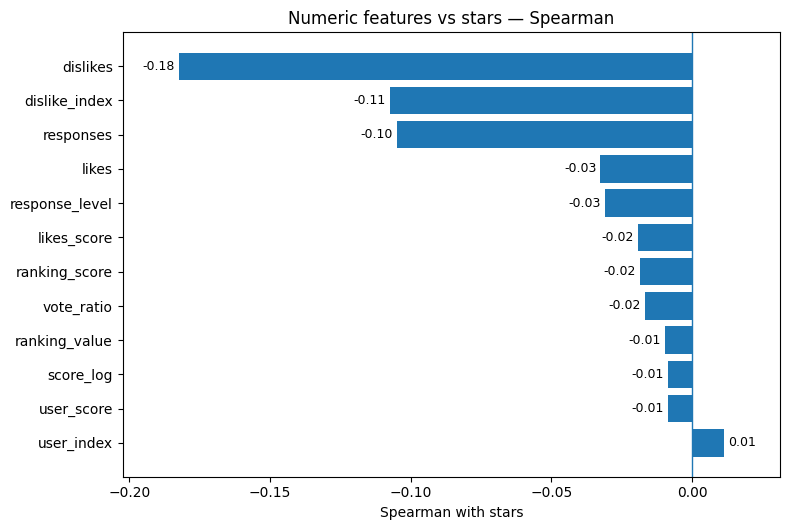

In [100]:
#Numeric values vs. TARGET=stars Spearman bar chart

TARGET = "stars"
exclude = {"stars", "recipe_number", "recipe_code", "created_at"}

#Compute Spearman(feature, stars)
num_cols = [c for c in data.select_dtypes(include=[np.number]).columns if c not in exclude]

rho = {}
for c in num_cols:
    sub = data[[c, TARGET]].dropna()
    if len(sub) >= 10:
        rho[c] = sub[TARGET].corr(sub[c], method="spearman")

#Sort by value
rho_s = pd.Series(rho).dropna().sort_values(ascending=False)

fig_h = max(4, 0.45 * len(rho_s))
fig, ax = plt.subplots(figsize=(8, fig_h))
y = np.arange(len(rho_s))
bars = ax.barh(y, rho_s.values)

ax.set_yticks(y)
ax.set_yticklabels(rho_s.index)
ax.set_xlabel("Spearman with stars")
ax.set_title("Numeric features vs stars — Spearman")
ax.axvline(0, linewidth=1)

xmin, xmax = float(rho_s.min()), float(rho_s.max())
pad = max(0.02, (xmax - xmin) * 0.08)
ax.set_xlim(xmin - pad, xmax + pad)

# annotate at the bar tips, on the correct side
for rect, val in zip(bars, rho_s.values):
    x = rect.get_width()
    y_mid = rect.get_y() + rect.get_height()/2
    ax.annotate(f"{val:.2f}", xy=(x, y_mid),
                xytext=(-3, 0) if x < 0 else (3, 0),
                textcoords="offset points",
                ha="right" if x < 0 else "left", va="center", fontsize=9)

plt.tight_layout()
plt.show()

* Biggest monotonic links to stars are negative and small: dislikes (≈ −0.18), dislike_index (≈ −0.11), responses (≈ −0.10).
* Everything else is near zero (|ρ| ≤ 0.03) — limited direct signal from the other numerics.

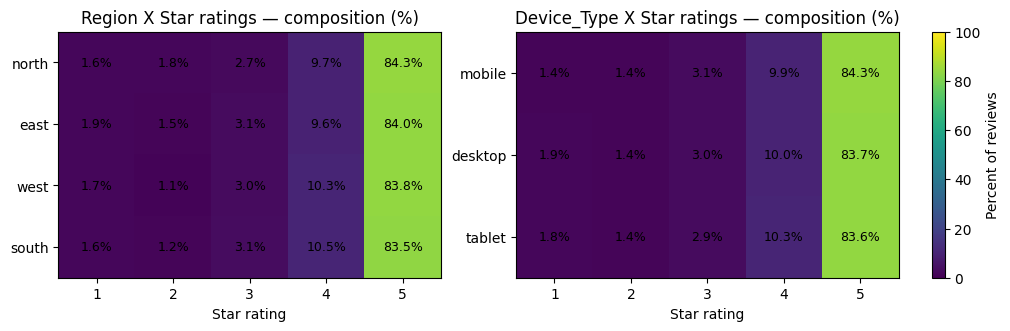

In [101]:
# RELATION TO STAR RATINGS — region vs stars

#Heatmap for Categorical × stars composition because line chart and stacked bar chart are not ideal

TARGET = "stars"
star_order = [1, 2, 3, 4, 5]
cats = [c for c in ["region", "device_type"] if c in data.columns]
assert len(cats) > 0, "Neither 'region' nor 'device_type' found."

def cat_shares(df, cat_col):
    tab = pd.crosstab(df[cat_col], df[TARGET]).reindex(columns=star_order, fill_value=0)
    shares = tab.div(tab.sum(axis=1), axis=0) * 100
    #Sort categories by 5★ share (desc) for readability
    return shares.sort_values(by=5, ascending=False)

shares_list = [(c, cat_shares(data, c)) for c in cats]
max_rows = max(s.shape[0] for _, s in shares_list)

n = len(shares_list)
fig_h = max(3.2, 0.5 * max_rows)
fig_w = 5.0 * n
fig, axes = plt.subplots(1, n, figsize=(fig_w, fig_h), constrained_layout=True)
if n == 1:
    axes = [axes]

vmin, vmax = 0, 100
ims = []
for ax, (name, shares) in zip(axes, shares_list):
    im = ax.imshow(shares.values, aspect="auto", vmin=vmin, vmax=vmax)
    ims.append(im)

    ax.set_xticks(range(len(star_order))); ax.set_xticklabels(star_order)
    ax.set_yticks(range(len(shares)));     ax.set_yticklabels(shares.index)
    ax.set_xlabel("Star rating")
    ax.set_title(f"{name.title()} X Star ratings — composition (%)")

    # annotate each cell with percent
    for i in range(shares.shape[0]):
        for j in range(shares.shape[1]):
            ax.text(j, i, f"{shares.iat[i, j]:.1f}%", ha="center", va="center", fontsize=9)

# single shared colorbar for all panels
cbar = fig.colorbar(ims[0], ax=axes, fraction=0.025, pad=0.04)
cbar.set_label("Percent of reviews")

plt.show()

Each category is ~84% 5-star, ~10% 4-star, and the rest very small; mean stars differ only by ~0.01–0.02 across category (so region and device types likely won’t be strong predictors).

review_len by stars:


,count,mean,median,std
stars,,,,
1,280,38.55,30.0,30.62
2,232,43.50,33.0,35.92
3,490,42.77,36.0,34.85
4,1655,42.50,34.0,36.29
5,13829,37.75,30.0,31.96


Spearman correlation between review_len and stars: -0.050


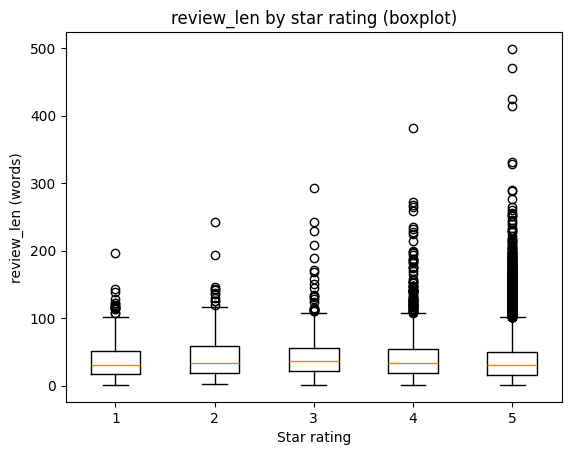

In [102]:
# RELATION TO STAR RATINGS — review_len (word count) vs stars
# Because text often carries the strongest signal for ratings; word count is a simple, explainable proxy.

TARGET = "stars"

#Create review_len as word count from 'text' (safe because we filled missing with "")
data["review_len"] = data["text"].astype(str).str.split().str.len().astype("int32")

#Summary table by star rating
grp = (data[[TARGET, "review_len"]]
       .groupby(TARGET)["review_len"]
       .agg(["count", "mean", "median", "std"])
       .round(2))
print("review_len by stars:")
display(grp)

#Strength/direction (Spearman handles skew)
rs = data[["review_len", TARGET]].corr(method="spearman").loc["review_len", TARGET]
print(f"Spearman correlation between review_len and {TARGET}: {rs:.3f}")

#Boxplot of review_len across star levels (distribution differences by class)
levels = sorted(data[TARGET].unique().tolist())
series_per_level = [data.loc[data[TARGET] == lv, "review_len"].values for lv in levels]

fig, ax = plt.subplots()
ax.boxplot(series_per_level)
ax.set_xticklabels([str(lv) for lv in levels])
ax.set_xlabel("Star rating")
ax.set_ylabel("review_len (words)")
ax.set_title("review_len by star rating (boxplot)")
plt.show()

Very slight negative association (Spearman ≈ −0.05). People tend to write a bit longer when ratings are lower, but the effect is small.

##### **Summary**

* Negative feedback shows the only noticeable link (still small)
* “Popularity/likes” metrics have ~no monotonic relation
* Text length is a tiny signal
* Categoricals add little by themselves - region and device_type have almost identical rating mixes (5 ≈ 83.5–84.3% in each).
* Likes-family (likes/likes_score/ranking_score/vote_ratio) are ~0.97–0.99 with each other; dislikes ≈ dislike_index (~0.99). These measure the same underlying behavior.

### **Exploratory Data Analysis (EDA) done.**

### **Feature Engineering**

In [103]:
#Transform or derive features

#Preconditions
assert "text" in data.columns, "Expected a 'text' column."

#To ensure text is string & create/reuse review length (words)
text_s = data["text"].fillna("").astype(str)
if "review_len" not in data.columns:
    data["review_len"] = text_s.str.split().str.len().astype("int32")
else:
    #To make sure it's numeric int
    data["review_len"] = pd.to_numeric(data["review_len"], errors="coerce").fillna(0).astype("int32")

#Exclamation intensity (normalized for length) -> To captures emotional emphasis independent of review length.
#exclamation count per 100 words = (exclam_count / review_len) × 100.
#exclam_per_100w = exclamation count per 100 words
exclam_count = text_s.str.count(r"!").astype("int32")
data["exclam_per_100w"] = (
    exclam_count / data["review_len"].replace(0, np.nan) * 100
).fillna(0).astype("float32")

#Complaint-word density (simple sentiment cue, normalized for length)
NEG_WORDS = [
    "bad","terrible","awful","horrible","disappointing","disappointed",
    "bland","soggy","salty","bitter","burnt","burned",
    "undercooked","overcooked","raw","dry","stale","cold",
    "hard","tough","rubbery","gross","nasty","worst"
]
neg_re = re.compile(r"\b(?:" + "|".join(map(re.escape, NEG_WORDS)) + r")\b", flags=re.I)
complaint_count = text_s.str.count(neg_re).astype("int32")
data["complaint_per_100w"] = (
    complaint_count / data["review_len"].replace(0, np.nan) * 100
).fillna(0).astype("float32")

#Log1p transforms for heavy-tailed counts
for col in ["responses", "user_score"]:
    if col in data.columns:
        data[f"{col}_log1p"] = np.log1p(pd.to_numeric(data[col], errors="coerce")).astype("float32")

#To show what I created/updated
created_cols = [c for c in [
    "review_len", "exclam_per_100w", "complaint_per_100w",
    "responses_log1p" if "responses_log1p" in data.columns else None,
    "user_score_log1p" if "user_score_log1p" in data.columns else None,
] if c]
print("Created/updated features:", created_cols)
display(data[created_cols].head(5))


Created/updated features: ['review_len', 'exclam_per_100w', 'complaint_per_100w', 'responses_log1p', 'user_score_log1p']


,review_len,exclam_per_100w,complaint_per_100w,responses_log1p,user_score_log1p
0,67,1.492537,0.0,0.0,0.693147
1,27,3.703704,0.0,0.0,3.931826
2,63,3.174603,0.0,0.0,2.397895
5,14,21.428572,0.0,0.0,0.693147
6,35,22.857143,0.0,0.0,0.693147


In [104]:
#Encode categorical variables

'''cat_cols = [c for c in ["region", "device_type"] if c in data.columns]
assert len(cat_cols) > 0, "No categorical columns found to encode."

# One-hot encode and append to `data`
dummies = pd.get_dummies(data[cat_cols], prefix=cat_cols, dtype="int8", drop_first=False)
data = pd.concat([data, dummies], axis=1)

# Quick summary of what was added
new_ohe_cols = list(dummies.columns)
print(f"Added {len(new_ohe_cols)} one-hot columns:")
print(new_ohe_cols)''' #This one added 7 columns for two categories

'cat_cols = [c for c in ["region", "device_type"] if c in data.columns]\nassert len(cat_cols) > 0, "No categorical columns found to encode."\n\n# One-hot encode and append to `data`\ndummies = pd.get_dummies(data[cat_cols], prefix=cat_cols, dtype="int8", drop_first=False)\ndata = pd.concat([data, dummies], axis=1)\n\n# Quick summary of what was added\nnew_ohe_cols = list(dummies.columns)\nprint(f"Added {len(new_ohe_cols)} one-hot columns:")\nprint(new_ohe_cols)'

In [105]:
#So instead, I will create two dummy columns as frequecy
cat_cols = [c for c in ["region", "device_type"] if c in data.columns]
assert len(cat_cols) > 0, "No 'region' / 'device_type' columns found."

for c in cat_cols:
    s = data[c].astype("string").fillna("Missing")
    freq = s.value_counts(normalize=True)  # proportion in [0,1]
    data[f"{c}_freq"] = s.map(freq).astype("float32")

print("Added encoded columns:", [f"{c}_freq" for c in cat_cols])
print("Current columns:", list(data.columns))

Added encoded columns: ['region_freq', 'device_type_freq']
Current columns: ['recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'text', 'stars', 'created_at_dt', 'review_len', 'exclam_per_100w', 'complaint_per_100w', 'responses_log1p', 'user_score_log1p', 'region_freq', 'device_type_freq']


In [106]:
#Normalize/scale features IN-PLACE (add *_z columns)

TARGET = "stars"

# Scale these if present (unbounded / wide-range):
to_scale = [
    "responses_log1p",    # log count
    "user_score_log1p",   # log count
    "ranking_value",      # continuous
    "review_len",         # words
    "exclam_per_100w",    # rate
    "complaint_per_100w", # rate
]

present = [c for c in to_scale if c in data.columns]

added = []
for c in present:
    s = pd.to_numeric(data[c], errors="coerce")
    mu = s.mean()
    sd = s.std(ddof=0)
    if np.isfinite(sd) and sd > 0:
        data[f"{c}_z"] = ((s - mu) / sd).astype("float32")
        added.append(f"{c}_z")

print("Scaled (z-score) columns added:", added)
if added:
    display(data[added].head())

Scaled (z-score) columns added: ['responses_log1p_z', 'user_score_log1p_z', 'ranking_value_z', 'review_len_z', 'exclam_per_100w_z', 'complaint_per_100w_z']


,responses_log1p_z,user_score_log1p_z,ranking_value_z,review_len_z,exclam_per_100w_z,complaint_per_100w_z
0,-0.096878,-0.235264,2.825874,0.875405,-0.140848,-0.133561
1,-0.096878,5.871576,4.140803,-0.352073,-0.081161,-0.133561
2,-0.096878,2.979203,4.116678,0.752657,-0.095443,-0.133561
5,-0.096878,-0.235264,2.668907,-0.751004,0.397291,-0.133561
6,-0.096878,-0.235264,5.028825,-0.106578,0.435853,-0.133561


In [107]:
data.shape

(16486, 37)

In [108]:
# 37 columns is too much. 
#PRUNE COLUMNS: keep only the final feature set + target

TARGET = "stars"

#Final keep list (presence-checked). 

KEEP_WISHLIST = [
    TARGET,                 # target
    "text",                 # keep for potential TF-IDF
    # numeric / ratios we use
    "vote_ratio", "dislike_index", "ranking_value",
    # transformed counts
    "responses_log1p", "user_score_log1p",
    # light text-derived cues
    "review_len", "exclam_per_100w", "complaint_per_100w",
    # compact categorical encodings
    "region_freq", "device_type_freq",
]

keep = [c for c in KEEP_WISHLIST if c in data.columns]
drop = [c for c in data.columns if c not in keep]

before_shape = data.shape
data = data.loc[:, keep].copy()   # in-place replace with pruned frame
after_shape  = data.shape

print("Kept columns ({}):".format(len(keep)), keep)
print("Dropped columns ({}):".format(len(drop)), drop)
print("Shape: {} -> {}".format(before_shape, after_shape))

Kept columns (12): ['stars', 'text', 'vote_ratio', 'dislike_index', 'ranking_value', 'responses_log1p', 'user_score_log1p', 'review_len', 'exclam_per_100w', 'complaint_per_100w', 'region_freq', 'device_type_freq']
Dropped columns (25): ['recipe_number', 'recipe_code', 'likes_score', 'response_level', 'user_index', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'created_at_dt', 'responses_log1p_z', 'user_score_log1p_z', 'ranking_value_z', 'review_len_z', 'exclam_per_100w_z', 'complaint_per_100w_z']
Shape: (16486, 37) -> (16486, 12)


In [109]:
data.to_csv('after.csv')

### **Feature Engineering done.**

### **Model Building and Model Evaluation**

#### Train/test split + preprocessing

In [110]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Train-only frequency encoder to avoid leakage.
    For each column c, replaces values with P(X=c) learned on X_train folds.
    """
    def __init__(self, cols):
        self.cols = cols
        self.maps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.cols)
        for c in self.cols:
            self.maps_[c] = X[c].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.cols)
        for c in self.cols:
            X[c] = X[c].map(self.maps_[c]).fillna(0.0)
        #To return a NumPy array to play nicely with ColumnTransformer
        return X.values


TARGET = "stars"
assert TARGET in data.columns, "Missing target 'stars'"

# Feature set we finalized in Feature Engineering
feature_candidates = [
    "vote_ratio", "dislike_index", "ranking_value",
    "responses_log1p", "user_score_log1p",
    "review_len", "exclam_per_100w", "complaint_per_100w",
    "region_freq", "device_type_freq",
]
features = [c for c in feature_candidates if c in data.columns]

#Leakage-safe swap: if raw categorical columns exist, prefer them over precomputed *_freq
raw_cat_cols = [c for c in ["region", "device_type"] if c in data.columns]
if len(raw_cat_cols) > 0:
    # drop *_freq from the feature list and use raw columns instead (to be frequency-encoded in-pipeline)
    features = [c for c in features if c not in ["region_freq", "device_type_freq"]]
    features += raw_cat_cols
    print("Using raw categorical columns for leakage-safe frequency encoding:", raw_cat_cols)
else:
    print("Raw categorical columns not found; using precomputed *_freq as provided.")

X = data[features].copy()
y = data[TARGET].astype(int)

print("Using features:", features)
print("X shape:", X.shape, "| y shape:", y.shape)

# Stratified split (class imbalance-aware)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "| Test:", X_test.shape)

# Preprocessing: scale only unbounded/continuous; pass ratios/frequencies as-is
#Add imputation inside the pipeline to avoid NaNs reaching estimators (median for continuous; 0 for ratios/frequencies)
scale_cols = [c for c in ["responses_log1p","user_score_log1p","ranking_value",
                          "review_len","exclam_per_100w","complaint_per_100w"] if c in features]

#To pass-through group starts as "everything else" in features, but we will exclude any raw categorical cols (handled by freq encoder)
pass_cols  = [c for c in features if c not in scale_cols]

#To remove them from pass_cols and set up a freq-encode group if we are using raw categorical columns.
cat_cols = [c for c in raw_cat_cols if c in features]
if len(cat_cols) > 0:
    pass_cols = [c for c in pass_cols if c not in cat_cols]

#Small pipelines: impute+scale for continuous; impute(0) for ratios/frequencies
scale_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
pass_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=0.0))
])

#To build transformer list
transformers = [
    ("scale", scale_pipe, scale_cols),
    ("pass",  pass_pipe,  pass_cols),
]
#To add leakage-safe frequency encoder if raw categorical columns are present
if len(cat_cols) > 0:
    transformers.append(("freq", FrequencyEncoder(cols=cat_cols), cat_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

print("To scale:", scale_cols)
print("Passthrough:", pass_cols)
if len(cat_cols) > 0:
    print("Frequency-encode (train-only):", cat_cols)

Xt_train = preprocessor.fit_transform(X_train)
Xt_test  = preprocessor.transform(X_test)

def _nancheck(name, arr):
    n = np.isnan(arr).sum()
    print(f"{name} -> shape {arr.shape}, NaNs: {n}")

_nancheck("Xt_train", Xt_train)
_nancheck("Xt_test", Xt_test)

Raw categorical columns not found; using precomputed *_freq as provided.
Using features: ['vote_ratio', 'dislike_index', 'ranking_value', 'responses_log1p', 'user_score_log1p', 'review_len', 'exclam_per_100w', 'complaint_per_100w', 'region_freq', 'device_type_freq']
X shape: (16486, 10) | y shape: (16486,)
Train: (13188, 10) | Test: (3298, 10)
To scale: ['responses_log1p', 'user_score_log1p', 'ranking_value', 'review_len', 'exclam_per_100w', 'complaint_per_100w']
Passthrough: ['vote_ratio', 'dislike_index', 'region_freq', 'device_type_freq']
Xt_train -> shape (13188, 10), NaNs: 0
Xt_test -> shape (3298, 10), NaNs: 0


Logistic Regression — CV (5-fold, refit=f1_macro)
 best params: {'clf__C': 0.25}
 mean CV macro-F1: 0.2908  (± 0.0171)
 mean CV accuracy : 0.6722  (± 0.0744)

Logistic Regression — Test metrics
 accuracy: 0.6913
 macro P|R|F1: 0.2645 | 0.3206 | 0.2796
 weighted P|R|F1: 0.7576 | 0.6913 | 0.7212
 macro ROC-AUC (OvR): 0.6886

              precision    recall  f1-score   support

           1      0.227     0.446     0.301        56
           2      0.055     0.152     0.081        46
           3      0.045     0.061     0.052        98
           4      0.112     0.151     0.129       331
           5      0.882     0.792     0.835      2767

    accuracy                          0.691      3298
   macro avg      0.265     0.321     0.280      3298
weighted avg      0.758     0.691     0.721      3298



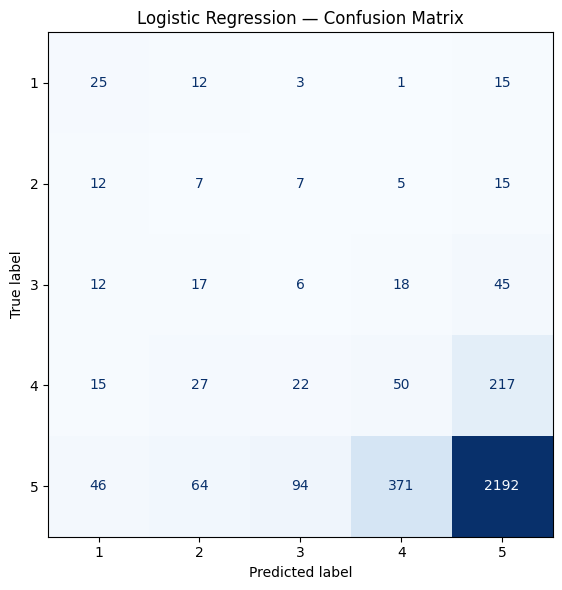

In [111]:
#MODEL 1: Logistic Regression (multinomial, class-balanced)
#Pipeline with CV tuning (refit on macro-F1)
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        # multi_class removed to avoid FutureWarning (sklearn>=1.5 defaults to multinomial)
        class_weight="balanced",
        penalty="l2",
        solver="lbfgs",
        max_iter=4000,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]}

grid = GridSearchCV(
    lr_pipe, param_grid=param_grid, cv=cv,
    scoring={"accuracy": "accuracy", "f1_macro": "f1_macro"},
    refit="f1_macro", n_jobs=-1, verbose=0, return_train_score=False
)

grid.fit(X_train, y_train)

#CV summary (for over/underfitting)
cv_results = pd.DataFrame(grid.cv_results_)
best_row = cv_results.loc[cv_results["rank_test_f1_macro"] == 1].iloc[0]
print("Logistic Regression — CV (5-fold, refit=f1_macro)")
print(f" best params: {grid.best_params_}")
print(f" mean CV macro-F1: {best_row['mean_test_f1_macro']:.4f}  (± {best_row['std_test_f1_macro']:.4f})")
print(f" mean CV accuracy : {best_row['mean_test_accuracy']:.4f}  (± {best_row['std_test_accuracy']:.4f})\n")

#Test-set evaluation
best_lr = grid.best_estimator_
y_pred  = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)

labels = sorted(np.unique(y))

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="weighted", zero_division=0
)

try:
    auc_macro_ovr = roc_auc_score(
        y_test, y_proba, multi_class="ovr", average="macro", labels=labels
    )
    auc_text = f"{auc_macro_ovr:.4f}"
except Exception:
    auc_text = "N/A (a class absent in y_test)"

print("Logistic Regression — Test metrics")
print(f" accuracy: {acc:.4f}")
print(f" macro P|R|F1: {prec_macro:.4f} | {rec_macro:.4f} | {f1_macro:.4f}")
print(f" weighted P|R|F1: {prec_weighted:.4f} | {rec_weighted:.4f} | {f1_weighted:.4f}")
print(f" macro ROC-AUC (OvR): {auc_text}\n")
print(classification_report(y_test, y_pred, labels=labels, digits=3, zero_division=0))

#Confusion matrix (True label vs Predicted label)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Logistic Regression — Confusion Matrix")
plt.tight_layout()
plt.show()

* Overall accuracy ~0.691 is driven mostly by predicting the dominant class (5).
* Macro F1 ≈ 0.280 → weak performance on minority classes (2/3/4 have very low F1).
* Confusion matrix: many true 2–4 reviews are pushed to 5 (and some to 4); class 5 has P=0.882, R=0.792.
* Cause: severe class imbalance + linear model on limited numeric signal → decision boundary favors class 5.

Random Forest — accuracy: 0.8266
macro P|R|F1: 0.3383 | 0.3052 | 0.3075
weighted P|R|F1: 0.7518 | 0.8266 | 0.7820
macro ROC-AUC (OvR): 0.7510

              precision    recall  f1-score   support

           1      0.418     0.411     0.414        56
           2      0.111     0.043     0.062        46
           3      0.152     0.071     0.097        98
           4      0.147     0.030     0.050       331
           5      0.863     0.970     0.913      2767

    accuracy                          0.827      3298
   macro avg      0.338     0.305     0.307      3298
weighted avg      0.752     0.827     0.782      3298



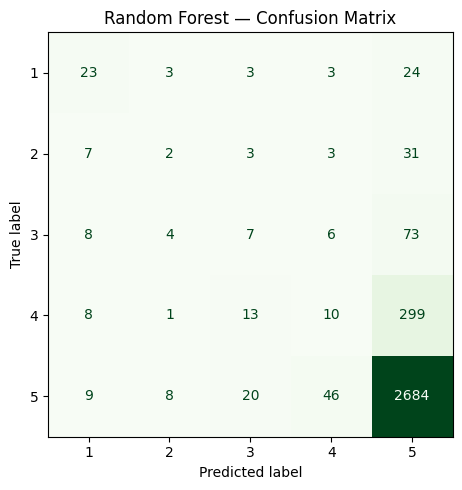

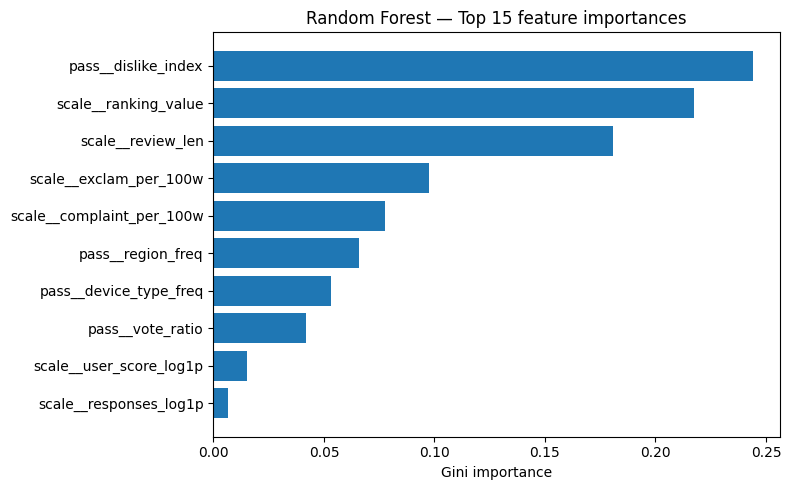

In [112]:
#MODEL #2: Random Forest (class-balanced)

# Pipeline
rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

# Fit
rf_pipe.fit(X_train, y_train)

# Predict
y_pred = rf_pipe.predict(X_test)
y_proba = rf_pipe.predict_proba(X_test)

# Metrics
labels = [1,2,3,4,5]
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="weighted", zero_division=0
)
auc_macro_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro", labels=labels)

print(f"Random Forest — accuracy: {acc:.4f}")
print(f"macro P|R|F1: {prec_macro:.4f} | {rec_macro:.4f} | {f1_macro:.4f}")
print(f"weighted P|R|F1: {prec_weighted:.4f} | {rec_weighted:.4f} | {f1_weighted:.4f}")
print(f"macro ROC-AUC (OvR): {auc_macro_ovr:.4f}\n")
print(classification_report(y_test, y_pred, labels=labels, digits=3, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Greens", values_format="d", colorbar=False)
ax.set_title("Random Forest — Confusion Matrix")
plt.tight_layout(); plt.show()

#Feature importance (top 15)
# Get feature names after preprocessing
feat_names = rf_pipe.named_steps["prep"].get_feature_names_out()
importances = rf_pipe.named_steps["clf"].feature_importances_

idx = np.argsort(importances)[::-1][:15]
top_names = np.array(feat_names)[idx]
top_vals  = importances[idx]

fig, ax = plt.subplots(figsize=(8,5))
ax.barh(range(len(top_vals)), top_vals[::-1])
ax.set_yticks(range(len(top_vals))); ax.set_yticklabels(top_names[::-1])
ax.set_xlabel("Gini importance")
ax.set_title("Random Forest — Top 15 feature importances")
plt.tight_layout()
plt.show()

* RF: acc 0.827, macro-F1 0.308, weighted-F1 0.782
* Minority classes are still weak.
* RF helps 1 (F1 ≈ 0.41 vs 0.30), but 2/3/4 remain very low.
* Accuracy is misleading because 5 dominates (~84%). 
* An “always 5” baseline would be ~0.839 accuracy; RF is close but a bit below that. 
* RF importances line up with EDA: dislike_index, ranking_value, review_len lead; vote_ratio, region_freq, device_type_freq are minor.

**We used a single-fit Random Forest (no CV) due to local compute limits; Logistic Regression covers the tuning requirement.**

**To improve the model**

I will add text features (TF-IDF) and a linear classifier
Because the Random Forest on numerics is near a majority-class baseline and can’t exploit raw text, while TF-IDF + multinomial Logistic turns reviews into high-dimensional sparse features where linear models are state-of-the-art (fast, well-regularized, better minority recall).
Tree ensembles generally struggle with sparse 50k+ features and get memory-heavy, but Logistic handles them efficiently and gives interpretable weights.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TF-IDF + Logistic (FAST) — Test metrics
 accuracy: 0.6880
 macro P|R|F1: 0.3564 | 0.5013 | 0.3909
 weighted P|R|F1: 0.8349 | 0.6880 | 0.7411
 macro ROC-AUC (OvR): 0.8144

              precision    recall  f1-score   support

           1      0.330     0.643     0.436        56
           2      0.115     0.283     0.164        46
           3      0.158     0.347     0.217        98
           4      0.224     0.505     0.310       331
           5      0.954     0.730     0.827      2767

    accuracy                          0.688      3298
   macro avg      0.356     0.501     0.391      3298
weighted avg      0.835     0.688     0.741      3298



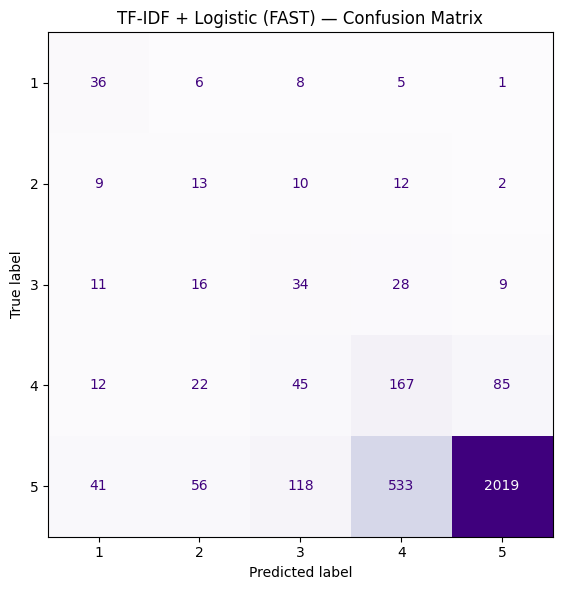

In [113]:
#MODEL 3: TF-IDF + Logistic Regression ( no CV)
#Reason: CV on large TF-IDF can be slow on CPU; this uses a compact vocab and one fit.

TEXT_COL = "text" 

#Small, fast TF-IDF (unigrams only, capped vocab)
text_pipe = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna("").astype(str), validate=False)),
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),       # unigrams = fast
        min_df=10,               # ignore very rare words
        max_df=0.95,
        max_features=8000,       # compact vocab -> big speedup
        sublinear_tf=True,
        strip_accents="unicode",
        lowercase=True,
        stop_words="english"     # reduces vocab further
    ))
])

#To Combine text with existing numeric preprocessor
prep_textnum = ColumnTransformer(
    transformers=[
        ("text", text_pipe, TEXT_COL),
        ("num",  preprocessor, list(X_train.columns)),
    ],
    remainder="drop",
    sparse_threshold=1.0  # keep sparse for speed/memory
)

tfidf_lr_fast = Pipeline([
    ("prep", prep_textnum),
    ("clf", LogisticRegression(
        solver="saga",          # handles high-dim sparse
        penalty="l2",
        C=1.0,                  # single-fit (no CV)
        class_weight="balanced",
        max_iter=3000,
        n_jobs=-1,
        random_state=42
    ))
])

#To build combined train/test frames (numeric + text col)
train_df = X_train.copy()
train_df[TEXT_COL] = data.loc[X_train.index, TEXT_COL]
test_df  = X_test.copy()
test_df[TEXT_COL]  = data.loc[X_test.index, TEXT_COL]

#Fit
tfidf_lr_fast.fit(train_df, y_train)

#Predict
y_pred  = tfidf_lr_fast.predict(test_df)
y_proba = tfidf_lr_fast.predict_proba(test_df)

#Metrics
labels = sorted(np.unique(y))
acc = accuracy_score(y_test, y_pred)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, average="weighted", zero_division=0
)
try:
    auc_macro_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro", labels=labels)
    auc_text = f"{auc_macro_ovr:.4f}"
except Exception:
    auc_text = "N/A"

print("TF-IDF + Logistic (FAST) — Test metrics")
print(f" accuracy: {acc:.4f}")
print(f" macro P|R|F1: {prec_m:.4f} | {rec_m:.4f} | {f1_m:.4f}")
print(f" weighted P|R|F1: {prec_w:.4f} | {rec_w:.4f} | {f1_w:.4f}")
print(f" macro ROC-AUC (OvR): {auc_text}\n")
print(classification_report(y_test, y_pred, labels=labels, digits=3, zero_division=0))

#Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, cmap="Purples", values_format="d", colorbar=False)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("TF-IDF + Logistic (FAST) — Confusion Matrix")
plt.tight_layout()
plt.show()